In [1]:
import sys 
sys.path.append("..")

import sympy
import numpy
from Common.utils import *

In [2]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', **{'size': 16})
plt.rcParams.update({
  "text.usetex": True
})

In [3]:
rbt, panda_def = load_robot_model()

# save Regressor as a py file
W_Regressor = sympybotics.robotcodegen.robot_code_to_func (
    'py' , rbt.H_code , 'H' , 'H_panda' , panda_def )

# calculate base parameters using QR decomposition
rbt.calc_base_parms()

generating geometric model
generating kinematic model
generating inverse dynamics code
generating gravity term code
generating coriolis term code
generating coriolis matrix code
generating inertia matrix code
generating regressor matrix code
done


In [18]:
# show base parameters
rbt.dyn.baseparms.evalf(prec=3)

Matrix([
[                                                                                  L_1zz + L_2yy],
[L_2xx - L_2yy + L_3yy + 0.632*l_3z + 0.0999*m_3 + 0.107*m_4 + 0.107*m_5 + 0.107*m_6 + 0.107*m_7],
[                                                                                          L_2xy],
[                                                                                          L_2xz],
[                                                                                          L_2yz],
[        L_2zz + L_3yy + 0.632*l_3z + 0.0999*m_3 + 0.107*m_4 + 0.107*m_5 + 0.107*m_6 + 0.107*m_7],
[                                                                                           l_2x],
[                        l_2y - l_3z - 0.316*m_3 - 0.316*m_4 - 0.316*m_5 - 0.316*m_6 - 0.316*m_7],
[                                                            L_3xx - L_3yy + L_4yy - 0.00681*m_4],
[                                                                            L_3xy + 0.0825*l_4z],
[

In [5]:
# Column independent regressor
regressor_func = (rbt.H_code[0], rbt.H_code[1][:,rbt.dyn.base_idxs])
W_Regressor = sympybotics.robotcodegen.robot_code_to_func (
    'py' , regressor_func , 'H' , 'H_panda_regressor' , panda_def )
#with open("regressor.py", 'w') as File:
#    File.write(W_Regressor)

#### Test regressor

In [6]:
from Common.regressor import *
import numpy as np

q = np.array([1.1,1.1,1.1,1.1,1.1,1.1,1.1])
H = H_panda_regressor(q,q,q)
H = np.array(H).reshape(7,43)

### Identification

#### Ordinary method with 5 th order harmonic stimulating trajectory

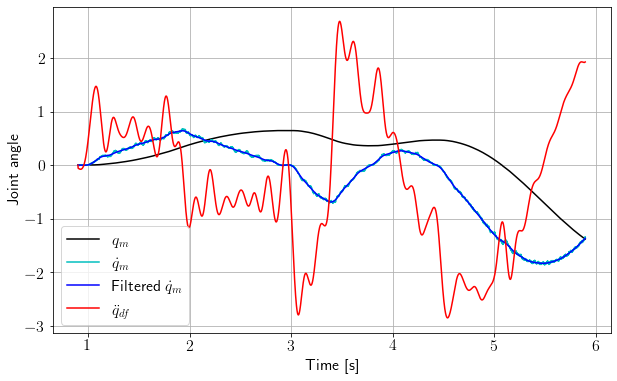

In [7]:
path = '../data/trajectories/traj16_z.panda.dat' # pick one trajectory
dataset = read_data(path)

time = dataset[:,0]
qDot_real = dataset[:,15:15+7]
q_real = dataset[:,1:1+7]
tau_real = dataset[:,29:29+7]

q_ref = dataset[:,8:8+7]
u_cmd = dataset[:, 22:22+7]
G_dat = dataset[:,36:36+7]
C_dat = dataset[:, 43:43+7]
M_dat = dataset[:, 50:50+49]
u_G = u_cmd + G_dat

channel = 6
qDot_real_filtered, tau_real_filtered = ButterWorthFilter(qDot_real, tau_real, time)

# numerical derivative to get joints acceleration.
qDDot_inf = numerical_grad_nd(qDot_real_filtered)

plt.figure(figsize=[10,6])
plt.plot(time[:5000], q_real[:5000,channel],'-k', label="$q_{m}$")
plt.plot(time[:5000], qDot_real[:5000,channel],'-c', label="$\dot{q}_{m}$")
plt.plot(time[:5000], qDot_real_filtered[:5000, channel],'-b', label="Filtered $\dot{q}_{m}$")
plt.plot(time[:5000], qDDot_inf[:5000,channel],'-r', label="$\ddot{q}_{df}$")
plt.xlabel("Time [s]")
plt.ylabel("Joint angle")
plt.grid()
plt.legend()
# plt.savefig('/home/jiayun/Desktop/joint.jpg', dpi=200)
plt.show()

In [19]:
## have to calculate MCG torques by hand
tau_MCG = []
for i in range(len(tau_real)):
    tau_i = M_dat[i,:].reshape(7,7) @ qDDot_inf[i, :].reshape(7,1)
    tau_i += C_dat[i,:].reshape(7,1)
    tau_i += G_dat[i,:].reshape(7,1)
    tau_MCG.append(tau_i)
    
tau_MCG = np.array(tau_MCG).reshape(len(tau_real), 7)

In [20]:
Yreg, Stack_tau = stack_regressor(time, q_real, qDot_real_filtered, qDDot_inf, tau_real_filtered)

The stacked regressor has 43 rank and it's condition number is 47.644931927861975.


In [21]:
q_real.shape

(23084, 7)

In [27]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

In [28]:
prop = 1 # proposition of the used data, for test reason
sample_number = int(len(time)*prop)*7
pi_s = np.linalg.pinv(Yreg[:sample_number,:]) @ Stack_tau[:sample_number, :]
print("Fitting results: \n", pi_s.T)

Fitting results: 
 [[-0.03245 1.14550 0.00737 -0.00505 -0.01865 1.07677 0.00460 -3.34776
  0.01371 -0.00028 -0.02730 0.02910 0.12623 0.71402 -0.00287 0.64025
  0.16163 -0.01212 0.00674 0.78689 -0.52299 2.05396 0.00807 -0.01008
  0.00223 0.01001 0.02677 0.00273 0.07580 0.00600 0.01019 -0.00430
  0.01083 0.04001 0.23694 -0.16334 -0.01232 0.00656 -0.00676 0.00014
  -0.00268 0.00246 0.00465]]


#### test the ordinary method 33974, 33953

The L1 error measurment is 1.6179805886516214.


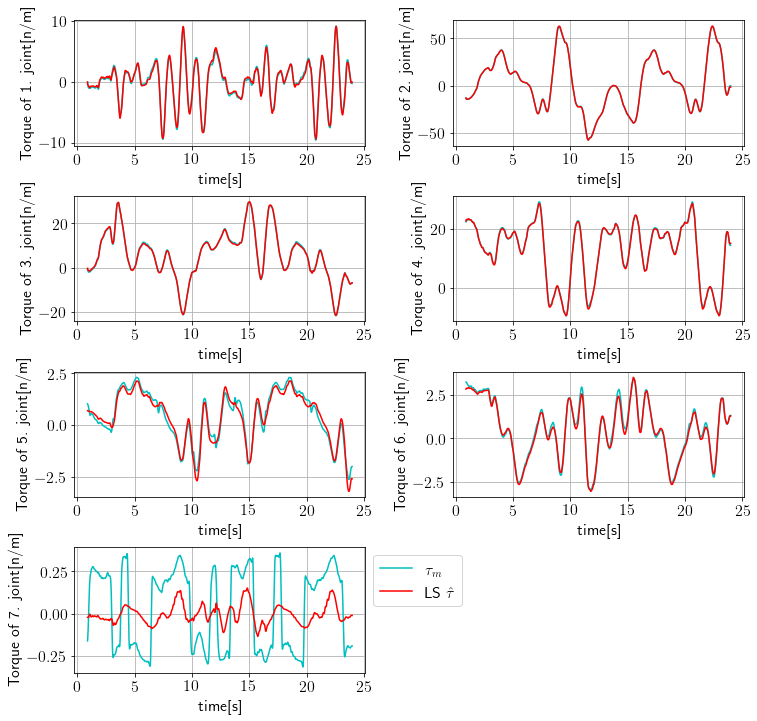

In [29]:
tau_approx = Yreg@pi_s
tau_approx = tau_approx.reshape(len(time),7)

error_measurement = np.abs(tau_approx - tau_real_filtered).sum() / len(tau_approx)
print("The L1 error measurment is {}.".format(error_measurement))

plt.figure(figsize=[12,12])

for channel in range(7):
    plt.subplot(4,2,channel+1,xlabel="time[s]", ylabel="Torque of {}. joint[n/m]".format(channel+1))
    plt.plot(time, tau_real_filtered[:,channel],'-c', label=r"$\tau_m$")
    plt.plot(time, tau_approx[:,channel],'-r', label=r"LS $\hat{\tau}$")
#     plt.plot(time, tau_MCG[:, channel], '-g', label=r"$\tau_{rbd}$")
    plt.grid()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.4)
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.savefig("/home/jiayun/Desktop/LS_evaluation.jpg", dpi=200)
plt.show()

In [30]:
output_to_matlab = rbt.dyn.baseparms - pi_s

#output = sympybotics.robotcodegen.robot_code_to_func (
#    'py' , output_to_matlab , 'obj' , 'obj_func' , panda_def )
#with open("regressor.py", 'w') as File:
#    File.write(W_Regressor)
from sympy.parsing.sympy_parser import parse_expr
#for i in range(len(output_to_matlab)):
#    print(output_to_matlab[i])

with open('pi_hat.txt','w') as F:
    for i in pi_s:
        F.write(str(i[0])+'\n')

#### Inverse Engineering Approach

#### The idea during the discussion in meeting
$M(q)_{:,i} = [Y(q,0,I_i) - Y(q,0,0)]\pi_B$  
Then we could extract the M corresponding low triangle entries in $[Y(q,0,I_i) - Y(q,0,0)]$ matrix to compose the regressor

- **Through experiment proved it's not working, it would generate full 0 matrix**

#### The diagram of static pose

The shape of dataset:  (119488, 99)


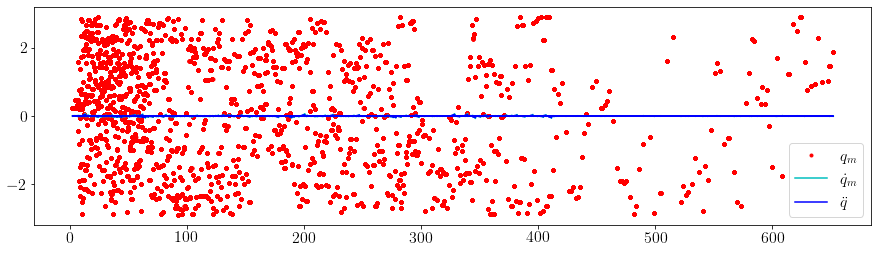

In [31]:
import glob

path1 = '../data/poses/first_poses.dat' # first sampled poses
path2 = '../data/poses/second_poses.dat' # second sampled poses
path3 = glob.glob('../data/poses/third_poses/*') # third sampled poses adress (a list)


dataset1 = read_data(path1)
dataset2 = read_data(path2)
dataset = np.concatenate((dataset1, dataset2), 0)

for addr in path3:
    dataset_temp = read_data(addr)
    dataset = np.concatenate((dataset, dataset_temp), 0)
    
print("The shape of dataset: ", dataset.shape)
    
time = dataset[:,0]
qDot_real = dataset[:,15:15+7]
q_real = dataset[:,1:1+7]
tau_real = dataset[:,29:29+7]

qDot_real_filtered, tau_real_filtered = ButterWorthFilter(qDot_real, tau_real, time)

qDDot_inf = numerical_grad_nd(qDot_real_filtered)

plt.figure(figsize=[15,4])
plt.plot(time, q_real[:,channel],'.r', label=r"$q_{m}$")
plt.plot(time, qDot_real[:,channel],'-c', label=r"$\dot{q}_{m}$")
plt.plot(time, qDot_real_filtered[:, channel],'-b', label=r"$\ddot{q}$")
#plt.plot(time, qDDot_inf[:,channel],'.y', label="qDDot_inf", alpha=0.7)
plt.legend()
plt.show()

#### Choose the middle point from those 100 msc sampling points and stack the left hand side of equation (20) in original paper.

In [32]:
M = dataset[:,-49:] # 7*7 matrix for each time step
G = dataset[:,36:36+7] # 7*1 vector for each time step

## here to set the non-informative first G to 0
G[:,0] = 0

Configurations, S = get_index_interval(q_real, M, G)
print("{} configurations found!".format(Configurations.shape[0]))

1191 configurations found!


#### Get the symbolic representation of inverse engineering regressor
1. $Y(q, \dot{q}, \ddot{q})\pi_s = \tau$  
2. $M(q)\ddot{q} + C(q,\dot{q})\dot{q} + G(q) = \tau$  
3. $RneForward(geometry) = kinetics\_result$  
4. $RneBackward(kinetics\_result, q, \dot{q}, \ddot{q}) = \tau$
5. $RneFB(q, \dot{q}, \ddot{q}) = \tau$


In [33]:
import time
start = time.time()

# symbolic inverse engineering regressor
Ys, G, M = ie_regressor(panda_def, rbt.dyn.geom)

end = time.time()
print("Done! It costs {:.2f} sec.".format(end-start))

Done! It costs 40.18 sec.


In [34]:
Ys.shape

(35, 70)

In [35]:
# convert symbolic expression to a function returning a numpy matrix
q1,q2,q3,q4,q5,q6,q7 = sympy.symbols("q1,q2,q3,q4,q5,q6,q7")
s = (q1,q2,q3,q4,q5,q6,q7)
regressor_func = sympy.lambdify(s, Ys, modules='numpy')

#### Start stacking reverse engineering regressor and the results
#### symbolic function is slow...

In [36]:
# start identification
base_idx = rbt.dyn.base_idxs

Y_s_dbar = np.zeros([35*Configurations.shape[0], len(base_idx)])

# stacking the regressor
for i, q in enumerate(Configurations):
    Y_s_bar = regressor_func(*q)[:, base_idx]
    Y_s_dbar[i*35:(i+1)*35, :] = Y_s_bar
Y_s_dbar = np.array(Y_s_dbar)

Y_s_dbar_cond = np.linalg.cond(Y_s_dbar)
Y_s_dbar_rank = np.linalg.matrix_rank(Y_s_dbar)

Pi_hat_sR = np.linalg.pinv(Y_s_dbar)@S
print('The Y_s_dbar regressor has {} rank and condition number {:.2f}.'.format(Y_s_dbar_rank, Y_s_dbar_cond))

The Y_s_dbar regressor has 43 rank and condition number 51.20.


In [39]:
S.shape

(41685, 1)

### Reverse Engineering Identification results

In [46]:
for sym, value in zip(rbt.dyn.baseparms, Pi_hat_sR):
    print("", '\t','%.5f' % np.array(value[0]))
    
with open('Pi_hat_sR.txt', 'w') as F:
    for i, n in enumerate(Pi_hat_sR):
        F.write('{} '.format(i+1) + str(n[0]) + '\n')

 	 0.02899
 	 1.06515
 	 -0.00533
 	 0.02841
 	 -0.00350
 	 1.12607
 	 -0.00572
 	 -3.34760
 	 0.01058
 	 -0.00028
 	 -0.01069
 	 -0.00480
 	 0.12747
 	 0.75113
 	 0.02375
 	 0.64217
 	 0.17498
 	 0.00475
 	 -0.00268
 	 0.75728
 	 -0.55331
 	 2.01729
 	 0.03821
 	 -0.00373
 	 -0.00614
 	 0.00770
 	 0.02412
 	 -0.01004
 	 0.07703
 	 0.00243
 	 0.01477
 	 -0.00001
 	 0.00082
 	 0.04611
 	 0.23428
 	 -0.17458
 	 -0.00325
 	 0.00118
 	 0.00239
 	 -0.00058
 	 0.00296
 	 -0.00156
 	 -0.00047


### Error Percentage

#### Overall percentage error - RE_regressor

In [47]:
print("Total error: ", np.linalg.norm(S - Y_s_dbar @ Pi_hat_sR) / np.linalg.norm(S))

Total error:  2.5478197985124605e-06


In [48]:
r, c = Y_s_dbar.shape

In [49]:
sigma_pho_2 = np.linalg.norm(S - Y_s_dbar @ Pi_hat_sR)**2 / (r-c)

In [50]:
temp = sigma_pho_2 * np.linalg.inv(Y_s_dbar.T @ Y_s_dbar)
E_var_hat = np.sqrt(np.diag(temp))

In [51]:
error_percent = []
for i, E_var_hat_k in enumerate(E_var_hat):
    error_percent_i = E_var_hat_k / np.abs(Pi_hat_sR[i][0])
    error_percent_i *= 100
    error_percent.append((i,error_percent_i))
sorted(error_percent, key=lambda x: x[1], reverse=True)

[(31, 1.7944794662284336),
 (9, 0.19330040225515216),
 (39, 0.03148764539417329),
 (32, 0.029654436368114486),
 (29, 0.023566353933239522),
 (4, 0.019036723146082447),
 (37, 0.016727476078161836),
 (18, 0.013756357083264092),
 (2, 0.012509130108031096),
 (36, 0.012269353895166379),
 (8, 0.010562797130350203),
 (11, 0.010403414915805816),
 (40, 0.009357327660366607),
 (23, 0.008493329657493767),
 (42, 0.008206014143693076),
 (17, 0.007581073858274602),
 (38, 0.00747121861004012),
 (24, 0.004068233350478603),
 (10, 0.0039511704930034865),
 (25, 0.003912804043430995),
 (0, 0.003080866124730333),
 (41, 0.002488010309971418),
 (3, 0.0022644640960963586),
 (26, 0.0020276892187006124),
 (22, 0.0018798067215954764),
 (30, 0.001592104347354575),
 (6, 0.001188136304051965),
 (33, 0.000797401709019087),
 (27, 0.000584980797636468),
 (12, 0.000529812197360332),
 (14, 0.00028931006600434693),
 (16, 0.00019517768604241409),
 (15, 0.0001392568244340373),
 (1, 0.0001343845114619269),
 (19, 7.147032010

#### Error percentage LS-Regressor

In [56]:
print("Total error: ", np.linalg.norm(Stack_tau - Yreg @ pi_s) / np.linalg.norm(Stack_tau))

Total error:  0.02163271243283017


In [57]:
r, c = Yreg.shape
sigma_pho_2 = np.linalg.norm(Stack_tau - Yreg @ pi_s) ** 2 / (r-c)

In [58]:
temp = sigma_pho_2 * np.linalg.inv(Yreg.T @ Yreg)
E_var_hat = np.sqrt(np.diag(temp))

In [59]:
error_percent = []
for i, E_var_hat_k in enumerate(E_var_hat):
    error_percent_i = E_var_hat_k / np.abs(pi_s[i][0])
    error_percent_i *= 100
    error_percent.append((i ,error_percent_i))
sorted(error_percent, key=lambda x: x[1], reverse=True)

[(9, 359.721373264353),
 (39, 242.59043996102676),
 (2, 25.30258436266107),
 (3, 25.193892469171576),
 (40, 18.559977895742918),
 (24, 17.260373244398494),
 (22, 14.552587679894874),
 (8, 13.022736959034816),
 (29, 12.62100043882722),
 (14, 12.501382560692416),
 (27, 12.004743816076319),
 (41, 11.015961352533669),
 (18, 10.249819473423564),
 (31, 8.894072508498729),
 (0, 8.123854745609647),
 (6, 6.85079375518315),
 (17, 6.4257494637804875),
 (4, 6.360933245925908),
 (23, 5.856837598676252),
 (38, 4.732554714683452),
 (25, 4.724612322235485),
 (32, 4.313522239037517),
 (42, 4.0553149306204475),
 (11, 3.8780312066061584),
 (37, 3.876584749424782),
 (36, 3.7572128625347534),
 (10, 3.656403604896298),
 (30, 3.433394773474089),
 (26, 3.1280572124214743),
 (33, 1.3712106323548754),
 (12, 1.0019697474890925),
 (28, 0.37259258481183916),
 (1, 0.3139742258567899),
 (16, 0.3056495384778383),
 (15, 0.20229845516806988),
 (5, 0.18019754960562986),
 (19, 0.15300841380636016),
 (35, 0.14379006960769

### Test on unseen data
#### Better prediction for relative small torque joints

#### relative estimation error

MAE of RE: 1.887


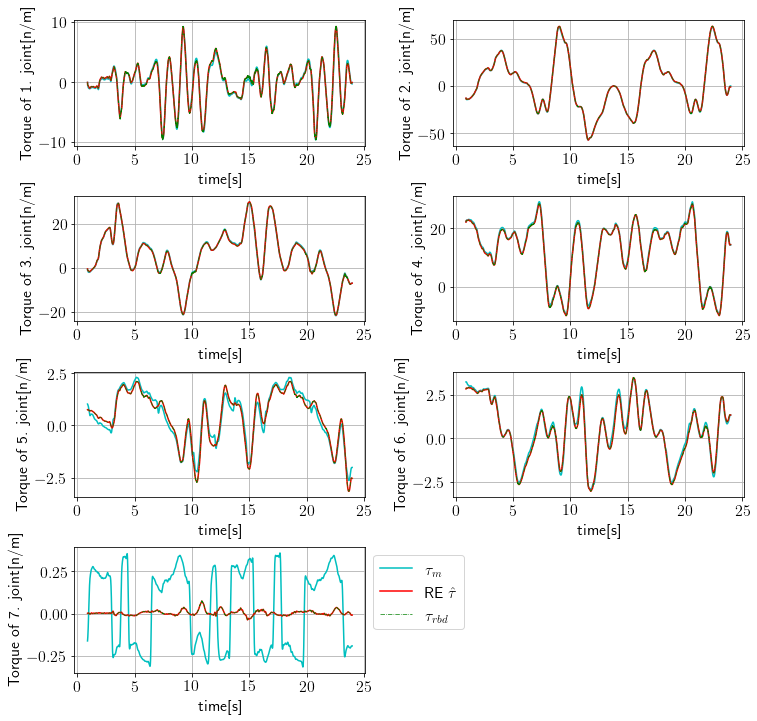

In [31]:
path = '../data/trajectories/traj16_z.panda.dat'
dataset = read_data(path)

time = dataset[:,0]
qDot_real = dataset[:,15:15+7]
q_real = dataset[:,1:1+7]
tau_real = dataset[:,29:29+7]

qDot_real_filtered, tau_real_filtered = ButterWorthFilter(qDot_real, tau_real, time)

tau_approx_RE = Yreg@Pi_hat_sR  # Yreg was stacked in the ordinary method
tau_approx_RE = tau_approx_RE.reshape(-1,7)
MAE = np.abs(tau_approx_RE - tau_real_filtered).sum() / len(tau_approx_RE)
print("MAE of RE: {:0.3f}".format(MAE))
###############################################################
plt.figure(figsize=[12,12])

for channel in range(7):
    plt.subplot(4,2,channel+1,xlabel="time[s]", ylabel="Torque of {}. joint[n/m]".format(channel+1))
    plt.plot(time, tau_real_filtered[:,channel],'-c', label=r"$\tau_m$")
    plt.plot(time, tau_approx_RE[:,channel],'-r', label=r"RE $\hat{\tau}$")
    plt.plot(time, tau_MCG[:, channel], '-.g', label=r"$\tau_{rbd}$", linewidth=.7)
    plt.grid()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.4)
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.savefig("/home/jiayun/Desktop/RE_evaluation.jpg", dpi=200)
plt.show()

### Friction and unmodeled dynamics fitting

In [32]:
max_len = 0
for i in range(7): # iterate through joints
    exec("path{0} = '../data/joints/joint{0}_z.panda.dat'".format(i))
    exec('dataset{0} = read_data(path{0})'.format(i))
    curr_len = eval('dataset{}.shape[0]'.format(i))
    if max_len < curr_len:
        max_len = curr_len
    
    exec('time{0} = dataset{0}[:,0]'.format(i))
    exec('q_real{0} = dataset{0}[:,1:1+7]'.format(i))
    exec('q_ref{0} = dataset{0}[:,8:8+7]'.format(i))
    exec('qDot_real{0} = dataset{0}[:,15:15+7]'.format(i))
    exec('u_cmd{0} = dataset{0}[:, 22:22+7]'.format(i))
    exec('tau_real{0} = dataset{0}[:,29:29+7]'.format(i))
    exec('Gra{0} = dataset{0}[:,36:36+7]'.format(i))

    exec('qDot_real_filtered{0}, tau_real_filtered{0} = ButterWorthFilter(qDot_real{0}, tau_real{0}, time{0})'.format(i))
    exec('u_G{0} = u_cmd{0}+Gra{0}'.format(i))
    exec('u_G_filtered{0}, Gra_filtered{0} = ButterWorthFilter(u_cmd{0}+Gra{0}, Gra{0}, time{0})'.format(i))

    exec('qDDot_inf{0} = numerical_grad_nd(qDot_real_filtered{0})'.format(i)) # numerical derivative to get joints acceleration.

### Time scale error plot
#### In each joint dataset the corresponding joints has the largest error, which is expected.

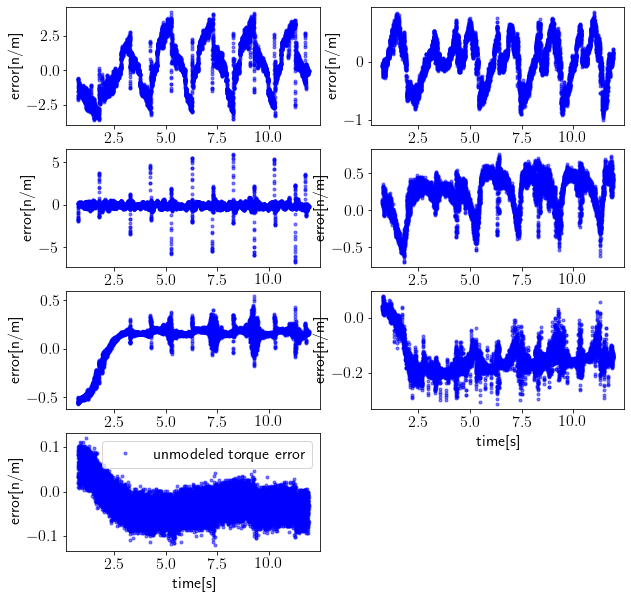

In [33]:
plt.figure(figsize=[10,10])
which_data = 0 # second dataset

for i in range(7):
    plt.subplot(4,2,i+1,xlabel="time[s]", ylabel="error[n/m]")
    Error_tau = eval('(u_cmd{0}+Gra{0})[:,i]-tau_real{0}[:,i]'.format(which_data))
    exec("plt.plot(time{0}, Error_tau,'.b',\
             alpha=0.5, label='unmodeled torque error')".format(which_data))

plt.legend()
plt.show()

In [34]:
# the definition of loss
def loss(x):
    phi1j, phi2j, phi3j = x
    temp = error - phi1j/(1+np.exp(-phi2j*(dqj+phi3j))) + phi1j/(1+np.exp(-phi2j*phi3j))
    l = np.linalg.norm(temp, 2)
    return l
    
def friction(x, speed):
    phi1j, phi2j, phi3j = x
    tau = phi1j/(1+np.exp(-phi2j*(speed+phi3j))) - phi1j/(1+np.exp(-phi2j*phi3j))
    return tau

In [89]:
for i in range(7):
    exec('Yreg{0}, Stack_tau{0} = stack_regressor(time{0}, q_real{0}, qDot_real_filtered{0},\
                                          qDDot_inf{0}, tau_real_filtered{0})'.format(i))
    exec('ieModel_tau{0} = Yreg{0} @ Pi_hat_sR'.format(i))
    exec('ieModel_tau{0} = ieModel_tau{0}.reshape(-1,7)'.format(i))

The stacked regressor has 43 rank and it's condition number is 38974.384881945065.
The stacked regressor has 43 rank and it's condition number is 12918.300672912583.
The stacked regressor has 43 rank and it's condition number is 17565838.350564215.
The stacked regressor has 43 rank and it's condition number is 264254148.8983904.
The stacked regressor has 42 rank and it's condition number is 1108765879777.8777.
The stacked regressor has 43 rank and it's condition number is 35570976929.703514.
The stacked regressor has 42 rank and it's condition number is 8486797506764.378.


### After using of the new joint data, the friction model fitting become well defined.

In [90]:
# calc torque from retrieved parameters, slow
from Common.M_matrix import M_panda
from Common.C_matrix import C_panda
from Common.G_vector import G_panda

for i in range(7):
    print("Generating the {} tau_inf...".format(i))
    exec('tau_inf{0}=calc_tau(M_panda, C_panda, G_panda, q_real{0}, qDot_real_filtered{0}, qDDot_inf{0})'.format(i))

Generating the 0 tau_inf...
Generating the 1 tau_inf...
Generating the 2 tau_inf...
Generating the 3 tau_inf...
Generating the 4 tau_inf...
Generating the 5 tau_inf...
Generating the 6 tau_inf...


(11167,)
(8557,)
(11147,)
(7160,)
(11189,)
(7149,)
(11146,)


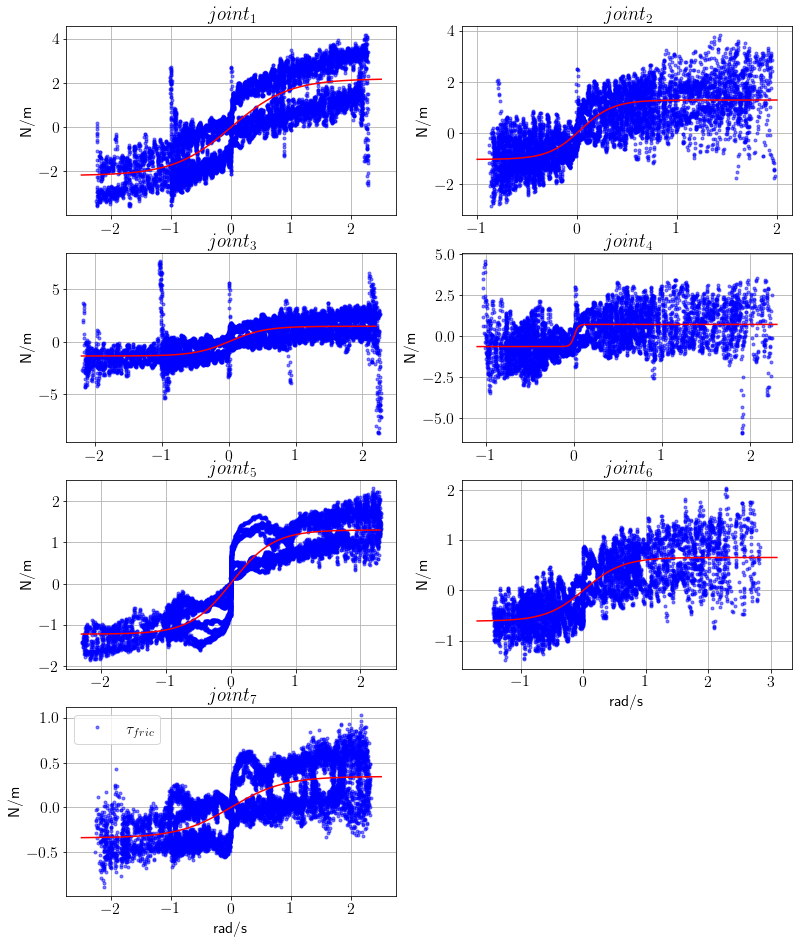

In [35]:
from scipy.optimize import minimize

parameter_x = []
plt.figure(figsize=[13,16])
s_max = [2.5, 2, 2.2, 2.3, 2.3, 3.1, 2.5]
s_min = [-2.5, -1, -2.2, -1.1, -2.3, -1.7, -2.5]
for joint in range(7):
    speed = np.linspace(s_min[joint], s_max[joint], dataset.shape[0])
    if joint==6 or joint==5:
        plt.subplot(4,2,joint+1,xlabel=r"rad/s",ylabel=r"N/m", title=r"$joint_{}$".format(joint+1))
    else:
        plt.subplot(4,2,joint+1,xlabel=r"",ylabel=r"N/m", title=r"$joint_{}$".format(joint+1))
    #error = eval("- tau_real{0}[:,{0}] + ieModel_tau{0}[:,{0}]".format(joint))      # from regressor
    #error = eval('tau_real{0}[:,{0}] - tau_inf{0}[:,{0}]'.format(joint))        # from retrieve
    error = eval('u_G{0}[:,joint] - tau_real{0}[:,joint]'.format(joint))  # from sensor
    print(error.shape)
    dqj = eval('qDot_real{0}[:,joint]'.format(joint))
    res = minimize(loss, x0=[1,1,1], method='Nelder-Mead',tol=1e-7)
    
    opt_x = res.x
    parameter_x.append(opt_x)
    fitted_tau = friction(opt_x, speed)
    plt.plot(dqj, error,'.b',\
             alpha=0.5, label=r'$\tau_{fric}$')
    plt.plot(speed, fitted_tau, '-r')
    plt.grid()
plt.legend()
plt.savefig("/home/jiayun/Desktop/fitted_model.jpg", dpi=200)
plt.show()

In [36]:
# optimal parameters below  
print ("{:<8} {:<8} {:<8} {:<8}".format('Joint','alpha1','alpha2', 'alpha3'))

for joint, v in enumerate(parameter_x):
    alpha1, alpha2, alpha3 = v
    print ("{:<8} {:<8.3f} {:<8.3f} {:<8.3f}".format( joint, alpha1, alpha2, alpha3))

Joint    alpha1   alpha2   alpha3  
0        4.398    2.090    0.003   
1        2.333    6.143    -0.035  
2        2.824    3.759    -0.022  
3        1.350    45.370   -0.002  
4        2.534    3.107    -0.018  
5        1.265    3.264    -0.018  
6        0.690    2.283    0.003   


In [47]:
np.save('../Common/fric_param.npy', parameter_x)

### Update 9. Jan, for residual dynamics

/home/jiayun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/jiayun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


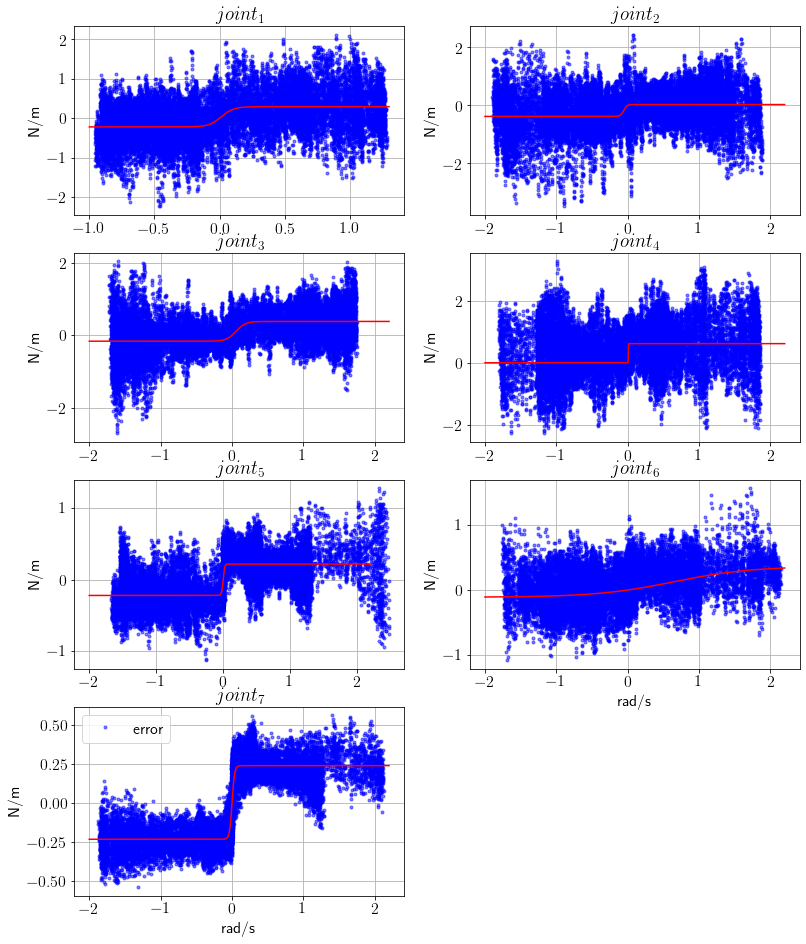

In [48]:
parameter_x = []
plt.figure(figsize=[13,16])
s_max = [1.3, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2]
s_min = [-1., -2., -2., -2., -2., -2., -2.]
for joint in range(7):
    speed = np.linspace(s_min[joint], s_max[joint], dataset.shape[0])
    if joint==6 or joint==5:
        plt.subplot(4,2,joint+1,xlabel="rad/s",ylabel="N/m", title=r"$joint_{}$".format(joint+1))
    else:
        plt.subplot(4,2,joint+1,xlabel="",ylabel="N/m", title=r"$joint_{}$".format(joint+1))

    error = tau_real[:, joint] - tau_MCG[:, joint]
    dqj = qDot_real[:, joint]
    res = minimize(loss, x0=[1,1,1], method='Nelder-Mead',tol=1e-7)
    
    opt_x = res.x
    parameter_x.append(opt_x)
    fitted_tau = friction(opt_x, speed)
    plt.plot(dqj, error,'.b',\
             alpha=0.5, label='error')
    plt.plot(speed, fitted_tau, '-r')
    plt.grid()
plt.legend()
plt.savefig("/home/jiayun/Desktop/fitted_residual_sig.jpg", dpi=150)
plt.show()

In [49]:
parameter_x = np.array(parameter_x)
parameter_x

array([[ 5.14225498e-01,  2.11566447e+01, -1.27812279e-02],
       [ 4.09651422e-01,  4.47430911e+01,  5.57963848e-02],
       [ 5.45922197e-01,  1.51076151e+01, -5.66426903e-02],
       [ 6.15313008e-01,  9.48338187e+02, -8.80951373e-03],
       [ 4.39828460e-01,  8.93929559e+01,  2.95703802e-04],
       [ 4.75478094e-01,  1.83821326e+00, -6.46823138e-01],
       [ 4.70002801e-01,  5.77225906e+01, -5.77805791e-04]])

In [50]:
np.save('../Common/residual_dynamics.npy', parameter_x)

## Final Evaluation

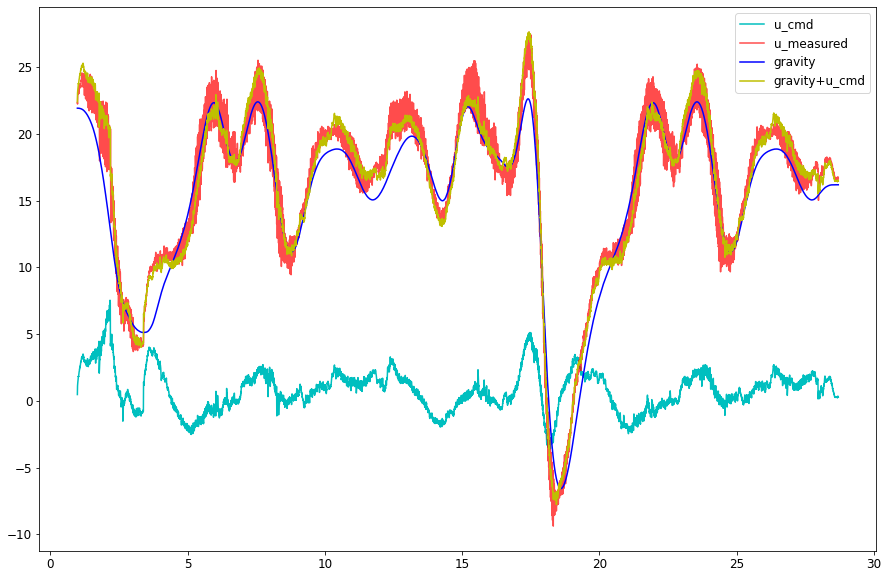

In [97]:
# import a new trajectory
path = '../data/trajectories/traj3_1.2_z.panda.dat'
dataset = read_data(path)

time = dataset[:,0]

indx = max(np.where(time<38)[0])
time = time[:indx]
q_real = dataset[:indx,1:1+7]
q_ref = dataset[:indx,8:8+7]
qDot_real = dataset[:indx,15:15+7]
u_cmd = dataset[:indx, 22:22+7]
tau_real = dataset[:indx,29:29+7]
Gra = dataset[:indx,36:36+7]
u_G = u_cmd + Gra

G_dat = dataset[:indx,36:36+7]
C_dat = dataset[:indx, 43:43+7]
M_dat = dataset[:indx, 50:50+49]

qDot_real_filtered, tau_real_filtered = ButterWorthFilter(qDot_real, tau_real, time)
qDot_real_filtered, u_G_filtered = ButterWorthFilter(qDot_real, u_G, time)

qDDot_inf = numerical_grad_nd(qDot_real_filtered) # numerical derivative to get joints acceleration.

channel = 3 # start from 0
    
plt.figure(figsize=[15,10])
plt.plot(time, u_cmd[:,channel],'-c', label="u_cmd")
plt.plot(time, tau_real[:,channel],'-r', label="u_measured", alpha=0.7)
plt.plot(time, Gra[:,channel],'-b', label='gravity')
plt.plot(time, u_cmd[:,channel]+Gra[:,channel],'-y', label='gravity+u_cmd')
plt.legend()
plt.show()

In [98]:
## have to calculate MCG torques by hand
tau_MCG = []
for i in range(len(tau_real)):
    tau_i = M_dat[i,:].reshape(7,7) @ qDDot_inf[i, :].reshape(7,1)
    tau_i += C_dat[i,:].reshape(7,1)
    tau_i += G_dat[i,:].reshape(7,1)
    tau_MCG.append(tau_i)
    
tau_MCG = np.array(tau_MCG).reshape(len(tau_real), 7)

In [99]:
# calc torque from retrieved parameters, slow
from Common.M_matrix import M_panda
from Common.C_matrix import C_panda
from Common.G_vector import G_panda
fric_parameters = np.load('../Common/fric_param.npy')

tau_inf_nofric, tau_inf_withfric = calc_tau(M_panda, C_panda, G_panda, q_real, \
                                     qDot_real_filtered, qDDot_inf, opt_x=fric_parameters)

#### Identifiled tau + friction torques

In [100]:
# calc torque from regressor
parameter_x = np.load('../Common/fric_param.npy')
Yreg, Stack_tau, friction_torque = stack_regressor(time, q_real, qDot_real_filtered, \
                qDDot_inf, tau_real_filtered, calc_friction_tau=True, opt_x=parameter_x)
    
tau_inf_nofric = Yreg@Pi_hat_sR
tau_inf_nofric = tau_inf_nofric.reshape(-1,7)
tau_inf_withfric = tau_inf_nofric + friction_torque

The stacked regressor has 43 rank and it's condition number is 69.83801116344237.


### Friction compensation for MCG model

In [101]:
def plot_test_results_with_friction(time, tau_real, tau_inf_nofric, tau_inf_withfric):
    plt.figure(figsize=[12,12])
    for channel in range(7):
        if channel==5 or channel==6:
            plt.subplot(4,2,channel+1,xlabel="time[s]", ylabel="Torque of {}. joint[n/m]".format(channel+1))
        else:
            plt.subplot(4,2,channel+1,xlabel="", ylabel="Torque of {}. joint[n/m]".format(channel+1))
        plt.plot(time, tau_real[:,channel],'-b', linewidth=1, label="u_real")
        plt.plot(time, tau_inf_nofric[:,channel],'-c', linewidth=2, label="u_predict")
        plt.plot(time, tau_inf_withfric[:,channel],'-r', linewidth=1, label="u_predict + friction")
    plt.legend()
    plt.savefig('evaluation.jpg', dpi=200)
    plt.show()

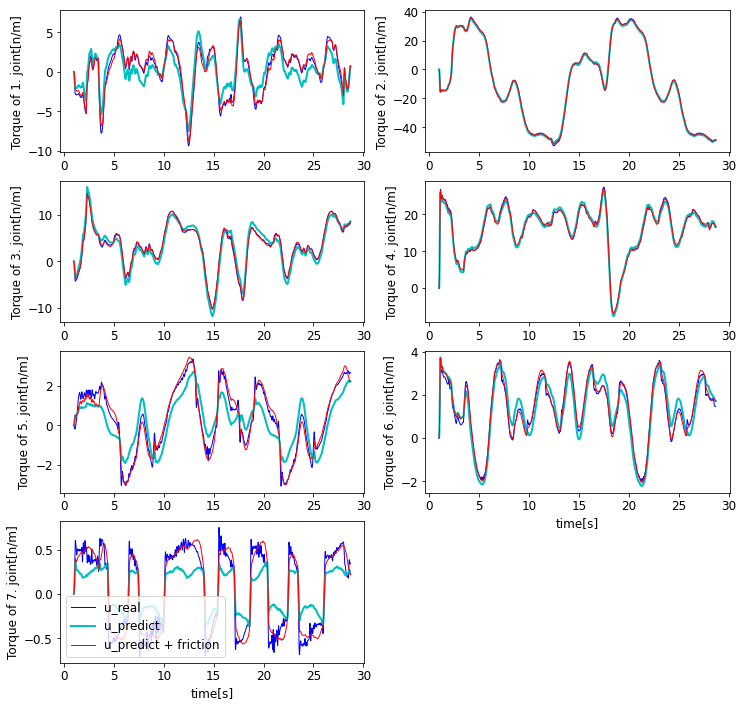

In [102]:
plot_test_results_with_friction(time, u_G_filtered, \
                                        tau_real_filtered, tau_real_filtered + friction_torque)

### MCG torque + Residual dynamics

The stacked regressor has 43 rank and it's condition number is 69.83801116344237.


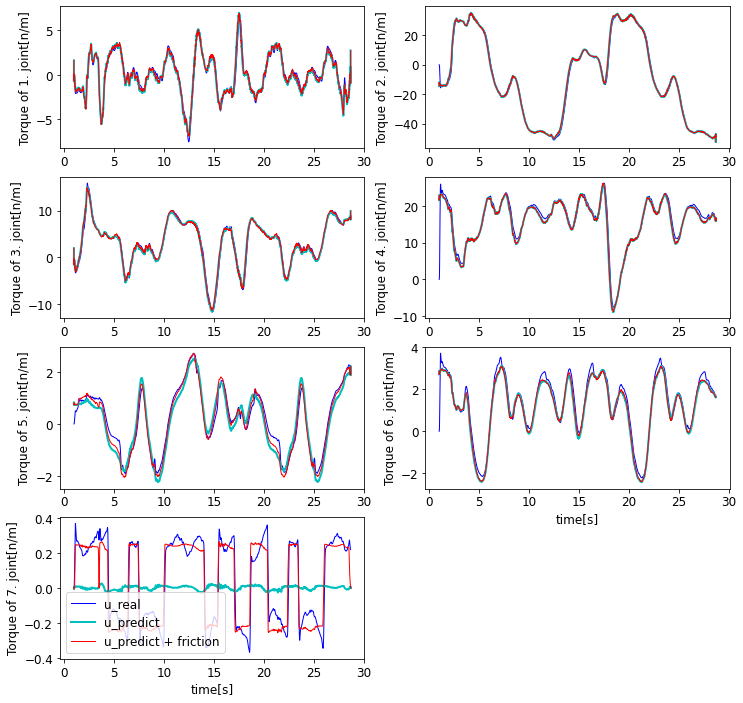

In [103]:
parameter_x = np.load('../Common/residual_dynamics.npy')
_, _, residual_dyna = stack_regressor(time, q_real, qDot_real_filtered, \
                qDDot_inf, tau_real_filtered, calc_friction_tau=True, opt_x=parameter_x)

plot_test_results_with_friction(time, tau_real_filtered, \
                                        tau_MCG, tau_MCG+residual_dyna)